### importing data and libraries

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set_context('notebook')
import pystan 
import stan_utility
import arviz as az
import patsy
import os,sys
import warnings 
import patsy
import pickle

#warnings.simplefilter('ignore')#removes deprecation warnings
plt.style.use('seaborn-ticks')

order = ["Accuracy","Speed"]
data = pd.read_csv('data_modelling_ready.csv')
original_data = pd.read_csv('../../data/EMG/clean_df.csv')


Amount and proportion of trials with RT > 2000 ms

In [3]:
print(len(original_data[original_data.rt > 2000].trial))
print(len(original_data[original_data.rt > 2000].trial)/len(original_data.trial) )

574
0.018949522960615365


Amout and proportion of trials with multiple EMG activities (flagged "MA")

In [5]:
print(len(original_data[original_data.trialType == "MA"].trial))
print(len(original_data[original_data.trialType == "MA"].trial)/len(original_data.trial))

8670
0.2862236307814202


In [6]:
print(data.groupby(['participant','SAT','p_right']).trial.count().mean())
print(data.groupby(['participant','SAT','p_right']).trial.count().min())
print(data.groupby(['participant','SAT','p_right']).trial.count().std())

209.625
104
49.52240322371918


In [7]:
print(len(original_data[original_data.response == 0].trial))
print(len(original_data[original_data.response == 0].trial)/len(original_data.trial))

5401
0.1783037866032815


In [54]:
print(len(original_data[(original_data.response == 1) & (original_data.SAT == "accuracy")].trial))
print(len(original_data[(original_data.response == 1) & (original_data.SAT == "accuracy")].trial)/len(original_data[(original_data.SAT == "accuracy")].trial))

12950
0.8845628415300546


## Note on factor coding and mixed models equation

Designed mixed model for latencies and proportion of correct responses : 
\begin{equation*}
y \sim SAT + Validity + Incorrect  + SAT:Validity + SAT:Incorrect + Validity:Incorrect + SAT:Validit:Incorrect
\end{equation*}

Notes on contrast coding : 

\begin{equation*}
SAT = \begin{pmatrix} 0 & Accuracy \\ 1 & Speed \end{pmatrix}
\end{equation*}

\begin{equation*}
Validity = \begin{pmatrix} -0.5 & Invalid \\ 0 & Even \\ 0.5 & Valid \end{pmatrix}
\end{equation*}

\begin{equation*}
Incorrect = \begin{pmatrix} 0 & Correct \\ 1 & Incorrect \end{pmatrix}
\end{equation*}

# Fitting GLME

In [8]:
Precision_fit = az.from_netcdf('MixedModels/FittedModels/Precision_fit.nc')

In [ ]:
az.from_netcdf('FittedModels/slope_fit.nc')

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


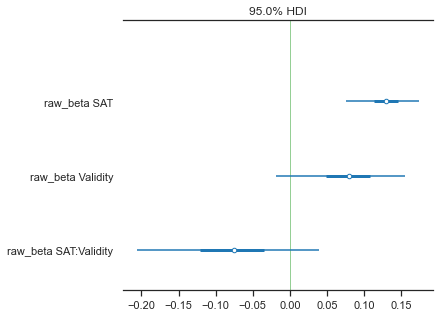

In [6]:
g = az.plot_forest(Precision_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, rope=[-0,0])
plt.show()


In [7]:
az.summary(Precision_fit, var_names=["raw_intercept","raw_beta"], round_to=2, hdi_prob=.95)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
raw_intercept  0.77  0.02      0.72       0.81        0.0      0.0   1669.28   
raw_beta[0]    0.13  0.02      0.08       0.17        0.0      0.0   1934.49   
raw_beta[1]    0.08  0.05     -0.02       0.15        0.0      0.0   2858.91   
raw_beta[2]   -0.08  0.06     -0.21       0.04        0.0      0.0   2890.03   

                ess_sd  ess_bulk  ess_tail  r_hat  
raw_intercept  1669.28   1671.14   2582.01    1.0  
raw_beta[0]    1909.46   1903.21   3250.90    1.0  
raw_beta[1]    2710.38   2824.21   3229.44    1.0  
raw_beta[2]    2855.35   2928.92   3621.26    1.0

Interestingly intercept + SAT = 90\% precision, the level of precision aimed using th eprior task !

In [31]:
az.hdi(Precision_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values

array([-0.12094129,  1.1581874 ])

In [52]:
GLMEdata

Unnamed: 0  response  participant  SAT  Validity
0               0         1            1    1      -0.5
1               1         1            1    1       0.0
2               2         1            1    1       0.5
3               3         1            1    1       0.5
4               4         1            1    1      -0.5
...           ...       ...          ...  ...       ...
20119       20119         1           16    1      -0.5
20120       20120         1           16    1      -0.5
20121       20121         1           16    1       0.5
20122       20122         1           16    1      -0.5
20123       20123         1           16    1      -0.5

[20124 rows x 5 columns]

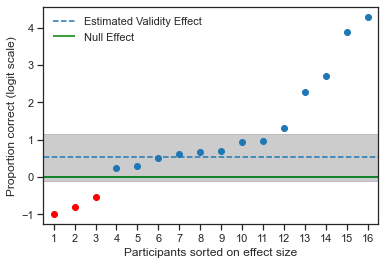

In [51]:
from scipy.special import expit

#fir, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
mean_Validity = Precision_fit.posterior.beta.sel(beta_dim_0=1).mean(axis=(0,1)).values 
indiv_Validity = mean_Validity + Precision_fit.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values

plt.plot(np.arange(16)[3:]+1, np.sort(indiv_Validity)[3:],'o')
plt.plot(np.arange(3)+1, np.sort(indiv_Validity)[:3],'o',color='r')
#plt.plot(16,ter_fit.posterior.beta.sel(b="FC").mean(axis=(0,1)), 'o', label="mean", color="b", markersize=10)
plt.hlines(0, -1, 17)

plt.hlines(mean_Validity, -1,17, linestyle='--', label="Estimated Validity Effect")
lower, upper = az.hdi(Precision_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[0], az.hdi(Precision_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
plt.fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)

#meanSATFC = ter_fit.posterior.beta.sel(b="SAT:FC").mean(axis=(0,1)).values
#indivSATFC = meanSATFC + ter_fit.posterior.u.sel(u_dim_1=4).mean(axis=(0,1)).values
plt.hlines(0, -1, 17,label="Null Effect", color="g")
plt.xlim(0.5,16.5)
plt.xticks(np.arange(16)+1)
#plt.title('Individual Effects of Validity on precision  \n\n', fontsize=15)
plt.ylabel('Proportion correct (logit scale)')
plt.legend(loc=0)
plt.xlabel('Participants sorted on effect size')
plt.show()

In [25]:
RT_fit = az.from_netcdf('MixedModels/FittedModels/RT_fit.nc')
PMT_fit = az.from_netcdf('MixedModels/FittedModels/PMT_fit.nc')
MT_fit = az.from_netcdf('MixedModels/FittedModels/MT_fit.nc')

### Analysis of RT

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


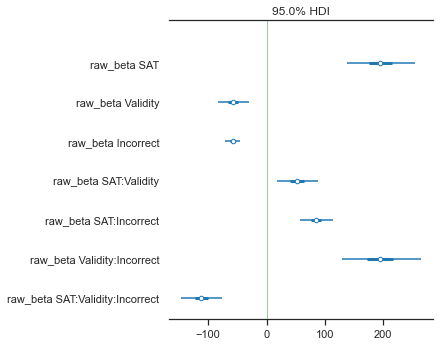

In [3]:
g = az.plot_forest(RT_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, rope=[-0,0])
plt.show()


In [4]:
az.summary(RT_fit, var_names=["raw_intercept","raw_beta"], round_to=0, hdi_prob=.95)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
raw_intercept  372.0  16.0     343.0      405.0        1.0      0.0    1022.0   
raw_beta[0]    195.0  30.0     137.0      255.0        1.0      1.0    1167.0   
raw_beta[1]    -57.0  13.0     -82.0      -31.0        0.0      0.0    1764.0   
raw_beta[2]    -58.0   7.0     -70.0      -45.0        0.0      0.0    2523.0   
raw_beta[3]     52.0  18.0      18.0       89.0        0.0      0.0    2407.0   
raw_beta[4]     85.0  14.0      57.0      114.0        0.0      0.0    2251.0   
raw_beta[5]    196.0  35.0     129.0      265.0        1.0      1.0    2488.0   
raw_beta[6]   -111.0  18.0    -147.0      -76.0        0.0      0.0    3090.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
raw_intercept  1022.0    1020.0    1686.0    1.0  
raw_beta[0]    1167.0    1168.0    1674.0    1.0  
raw_beta[1]    1764.0    1774.0    2648.0    1.0  
raw_beta[2]    2461.0    2530.0    3254.0    1.0  
raw_beta[3]    2407.0    2408.0    3861.0    1.0  
raw_beta[4]    2241.0    2274.0    3763.0    1.0  
raw_beta[5]    2488.0    2479.0    4028.0    1.0  
raw_beta[6]    2924.0    3065.0    3866.0    1.0

### Analysis of PMT

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


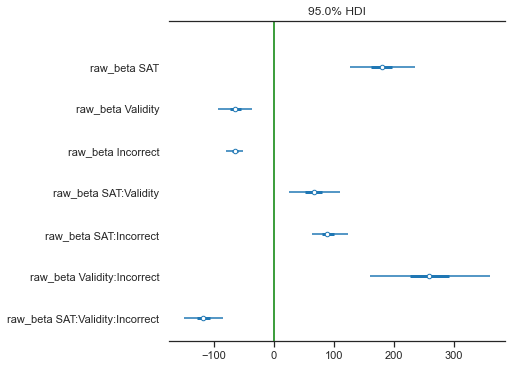

In [8]:
g = az.plot_forest(PMT_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, figsize=(7,5))
plt.vlines(0,-1,10, 'g')
plt.show()


In [30]:
az.summary(PMT_fit, var_names=["raw_intercept","raw_beta"], round_to=2, hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
raw_intercept  293.14  17.59    261.83     330.74       0.59     0.42   
raw_beta[0]    180.20  27.37    127.85     236.05       0.79     0.56   
raw_beta[1]    -64.75  14.36    -93.64     -37.29       0.37     0.26   
raw_beta[2]    -65.28   7.25    -79.74     -51.27       0.15     0.11   
raw_beta[3]     66.92  21.77     24.27     111.03       0.49     0.35   
raw_beta[4]     90.28  15.60     62.94     124.24       0.35     0.25   
raw_beta[5]    261.00  50.55    160.55     360.80       1.07     0.76   
raw_beta[6]   -117.57  16.40   -150.15     -85.50       0.30     0.21   

               ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
raw_intercept    886.93   886.93    880.94   1598.82   1.01  
raw_beta[0]     1198.84  1184.66   1202.81   1893.42   1.01  
raw_beta[1]     1519.66  1507.68   1511.67   2813.09   1.00  
raw_beta[2]     2326.60  2277.55   2360.05   3136.09   1.00  
raw_beta[3]     1984.10  1984.10   1974.77   3183.49   1.00  
raw_beta[4]     1985.77  1984.30   2000.84   3355.34   1.00  
raw_beta[5]     2224.23  2224.23   2225.61   3356.24   1.00  
raw_beta[6]     2929.62  2929.62   2929.97   4130.89   1.00

### Analysis of MT

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


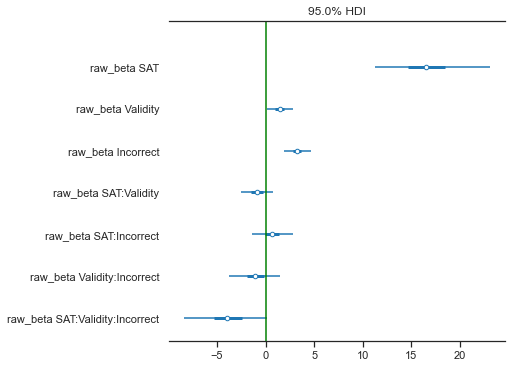

In [21]:
g = az.plot_forest(MT_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, figsize=(7,5))
plt.vlines(0,-1,10, 'g')
#plt.xlim(-30,100)
plt.show()


In [29]:
az.summary(MT_fit, var_names=["raw_intercept","raw_beta"], round_to=2, hdi_prob=.95)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
raw_intercept  68.12  4.10     60.28      76.26       0.14     0.10    812.96   
raw_beta[0]    16.66  3.01     11.22      23.11       0.10     0.07    966.38   
raw_beta[1]     1.44  0.66      0.18       2.80       0.01     0.01   5474.37   
raw_beta[2]     3.25  0.68      1.93       4.64       0.01     0.01   4017.62   
raw_beta[3]    -0.90  0.87     -2.58       0.79       0.01     0.01   5212.33   
raw_beta[4]     0.64  1.09     -1.41       2.86       0.01     0.01   5458.62   
raw_beta[5]    -1.06  1.34     -3.78       1.50       0.02     0.01   4620.46   
raw_beta[6]    -3.93  2.19     -8.40       0.16       0.03     0.02   5127.17   

                ess_sd  ess_bulk  ess_tail  r_hat  
raw_intercept   807.49    823.69   1467.51    1.0  
raw_beta[0]     966.38    961.97   1401.92    1.0  
raw_beta[1]    5309.49   5472.82   4805.81    1.0  
raw_beta[2]    3956.11   4054.14   3816.68    1.0  
raw_beta[3]    4674.16   5226.31   4572.37    1.0  
raw_beta[4]    3824.50   5462.67   3805.51    1.0  
raw_beta[5]    4533.40   4623.49   4431.10    1.0  
raw_beta[6]    4345.77   5184.29   4147.84    1.0

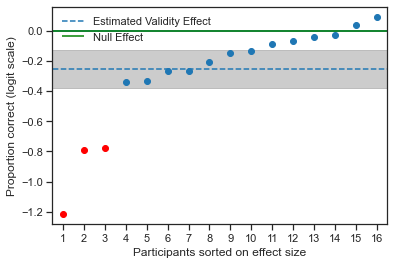

In [9]:
from scipy.special import expit

#fir, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
mean_Validity = PMT_fit.posterior.beta.sel(beta_dim_0=1).mean(axis=(0,1)).values 
indiv_Validity = mean_Validity + PMT_fit.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values

plt.plot(np.arange(16)[3:]+1, np.sort(indiv_Validity)[3:],'o')
plt.plot(np.arange(3)+1, np.sort(indiv_Validity)[:3],'o',color='r')
#plt.plot(16,ter_fit.posterior.beta.sel(b="FC").mean(axis=(0,1)), 'o', label="mean", color="b", markersize=10)
plt.hlines(0, -1, 17)

plt.hlines(mean_Validity, -1,17, linestyle='--', label="Estimated Validity Effect")
lower, upper = az.hdi(PMT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[0], az.hdi(PMT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
plt.fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)

#meanSATFC = ter_fit.posterior.beta.sel(b="SAT:FC").mean(axis=(0,1)).values
#indivSATFC = meanSATFC + ter_fit.posterior.u.sel(u_dim_1=4).mean(axis=(0,1)).values
plt.hlines(0, -1, 17,label="Null Effect", color="g")
plt.xlim(0.5,16.5)
plt.xticks(np.arange(16)+1)
#plt.title('Individual Effects of Validity on precision  \n\n', fontsize=15)
plt.ylabel('Proportion correct (logit scale)')
plt.legend(loc=0)
plt.xlabel('Participants sorted on effect size')
plt.show()

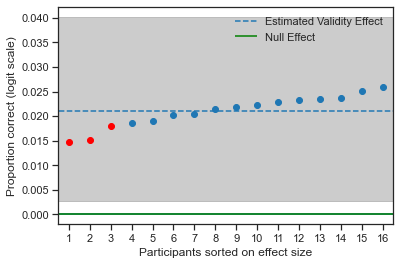

In [31]:
from scipy.special import expit

#fir, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
mean_Validity = MT_fit.posterior.beta.sel(beta_dim_0=1).mean(axis=(0,1)).values 
indiv_Validity = mean_Validity + MT_fit.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values

plt.plot(np.arange(16)[3:]+1, np.sort(indiv_Validity)[3:],'o')
plt.plot(np.arange(3)+1, np.sort(indiv_Validity)[:3],'o',color='r')
#plt.plot(16,ter_fit.posterior.beta.sel(b="FC").mean(axis=(0,1)), 'o', label="mean", color="b", markersize=10)
plt.hlines(0, -1, 17)

plt.hlines(mean_Validity, -1,17, linestyle='--', label="Estimated Validity Effect")
lower, upper = az.hdi(MT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[0], az.hdi(MT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
plt.fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)

#meanSATFC = ter_fit.posterior.beta.sel(b="SAT:FC").mean(axis=(0,1)).values
#indivSATFC = meanSATFC + ter_fit.posterior.u.sel(u_dim_1=4).mean(axis=(0,1)).values
plt.hlines(0, -1, 17,label="Null Effect", color="g")
plt.xlim(0.5,16.5)
plt.xticks(np.arange(16)+1)
#plt.title('Individual Effects of Validity on precision  \n\n', fontsize=15)
plt.ylabel('Proportion correct (logit scale)')
plt.legend(loc=0)
plt.xlabel('Participants sorted on effect size')
plt.show()

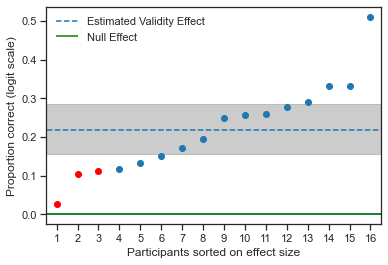

In [10]:
from scipy.special import expit

#fir, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
mean_Validity = MT_fit.posterior.beta.sel(beta_dim_0=0).mean(axis=(0,1)).values 
indiv_Validity = mean_Validity + MT_fit.posterior.u.sel(u_dim_1=1).mean(axis=(0,1)).values

plt.plot(np.arange(16)[3:]+1, np.sort(indiv_Validity)[3:],'o')
plt.plot(np.arange(3)+1, np.sort(indiv_Validity)[:3],'o',color='r')
#plt.plot(16,ter_fit.posterior.beta.sel(b="FC").mean(axis=(0,1)), 'o', label="mean", color="b", markersize=10)
plt.hlines(0, -1, 17)

plt.hlines(mean_Validity, -1,17, linestyle='--', label="Estimated Validity Effect")
lower, upper = az.hdi(MT_fit.posterior.beta.sel(beta_dim_0=0), hdi_prob=.95).beta.values[0], az.hdi(MT_fit.posterior.beta.sel(beta_dim_0=0), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
plt.fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)

#meanSATFC = ter_fit.posterior.beta.sel(b="SAT:FC").mean(axis=(0,1)).values
#indivSATFC = meanSATFC + ter_fit.posterior.u.sel(u_dim_1=4).mean(axis=(0,1)).values
plt.hlines(0, -1, 17,label="Null Effect", color="g")
plt.xlim(0.5,16.5)
plt.xticks(np.arange(16)+1)
#plt.title('Individual Effects of Validity on precision  \n\n', fontsize=15)
plt.ylabel('Proportion correct (logit scale)')
plt.legend(loc=0)
plt.xlabel('Participants sorted on effect size')
plt.show()

## Coefficient summary plot

In [10]:
az.summary(Precision_fit, var_names=['raw_intercept','raw_beta'], hdi_prob=.95).to_latex()

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &   mean &     sd &  hdi\\_2.5\\% &  hdi\\_97.5\\% &  mcse\\_mean &  mcse\\_sd &  ess\\_mean &  ess\\_sd &  ess\\_bulk &  ess\\_tail &  r\\_hat \\\\\n\\midrule\nraw\\_intercept &  0.766 &  0.024 &     0.718 &      0.811 &      0.001 &    0.000 &    1669.0 &  1669.0 &    1671.0 &    2582.0 &    1.0 \\\\\nraw\\_beta[0]   &  0.129 &  0.025 &     0.076 &      0.174 &      0.001 &    0.000 &    1934.0 &  1909.0 &    1903.0 &    3251.0 &    1.0 \\\\\nraw\\_beta[1]   &  0.076 &  0.046 &    -0.019 &      0.155 &      0.001 &    0.001 &    2859.0 &  2710.0 &    2824.0 &    3229.0 &    1.0 \\\\\nraw\\_beta[2]   & -0.080 &  0.064 &    -0.206 &      0.039 &      0.001 &    0.001 &    2890.0 &  2855.0 &    2929.0 &    3621.0 &    1.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

Sommaire de tous les coefficient plots pour mettre en perspective les effets

Text(0.5, 0, '$\\beta$ (ms)')

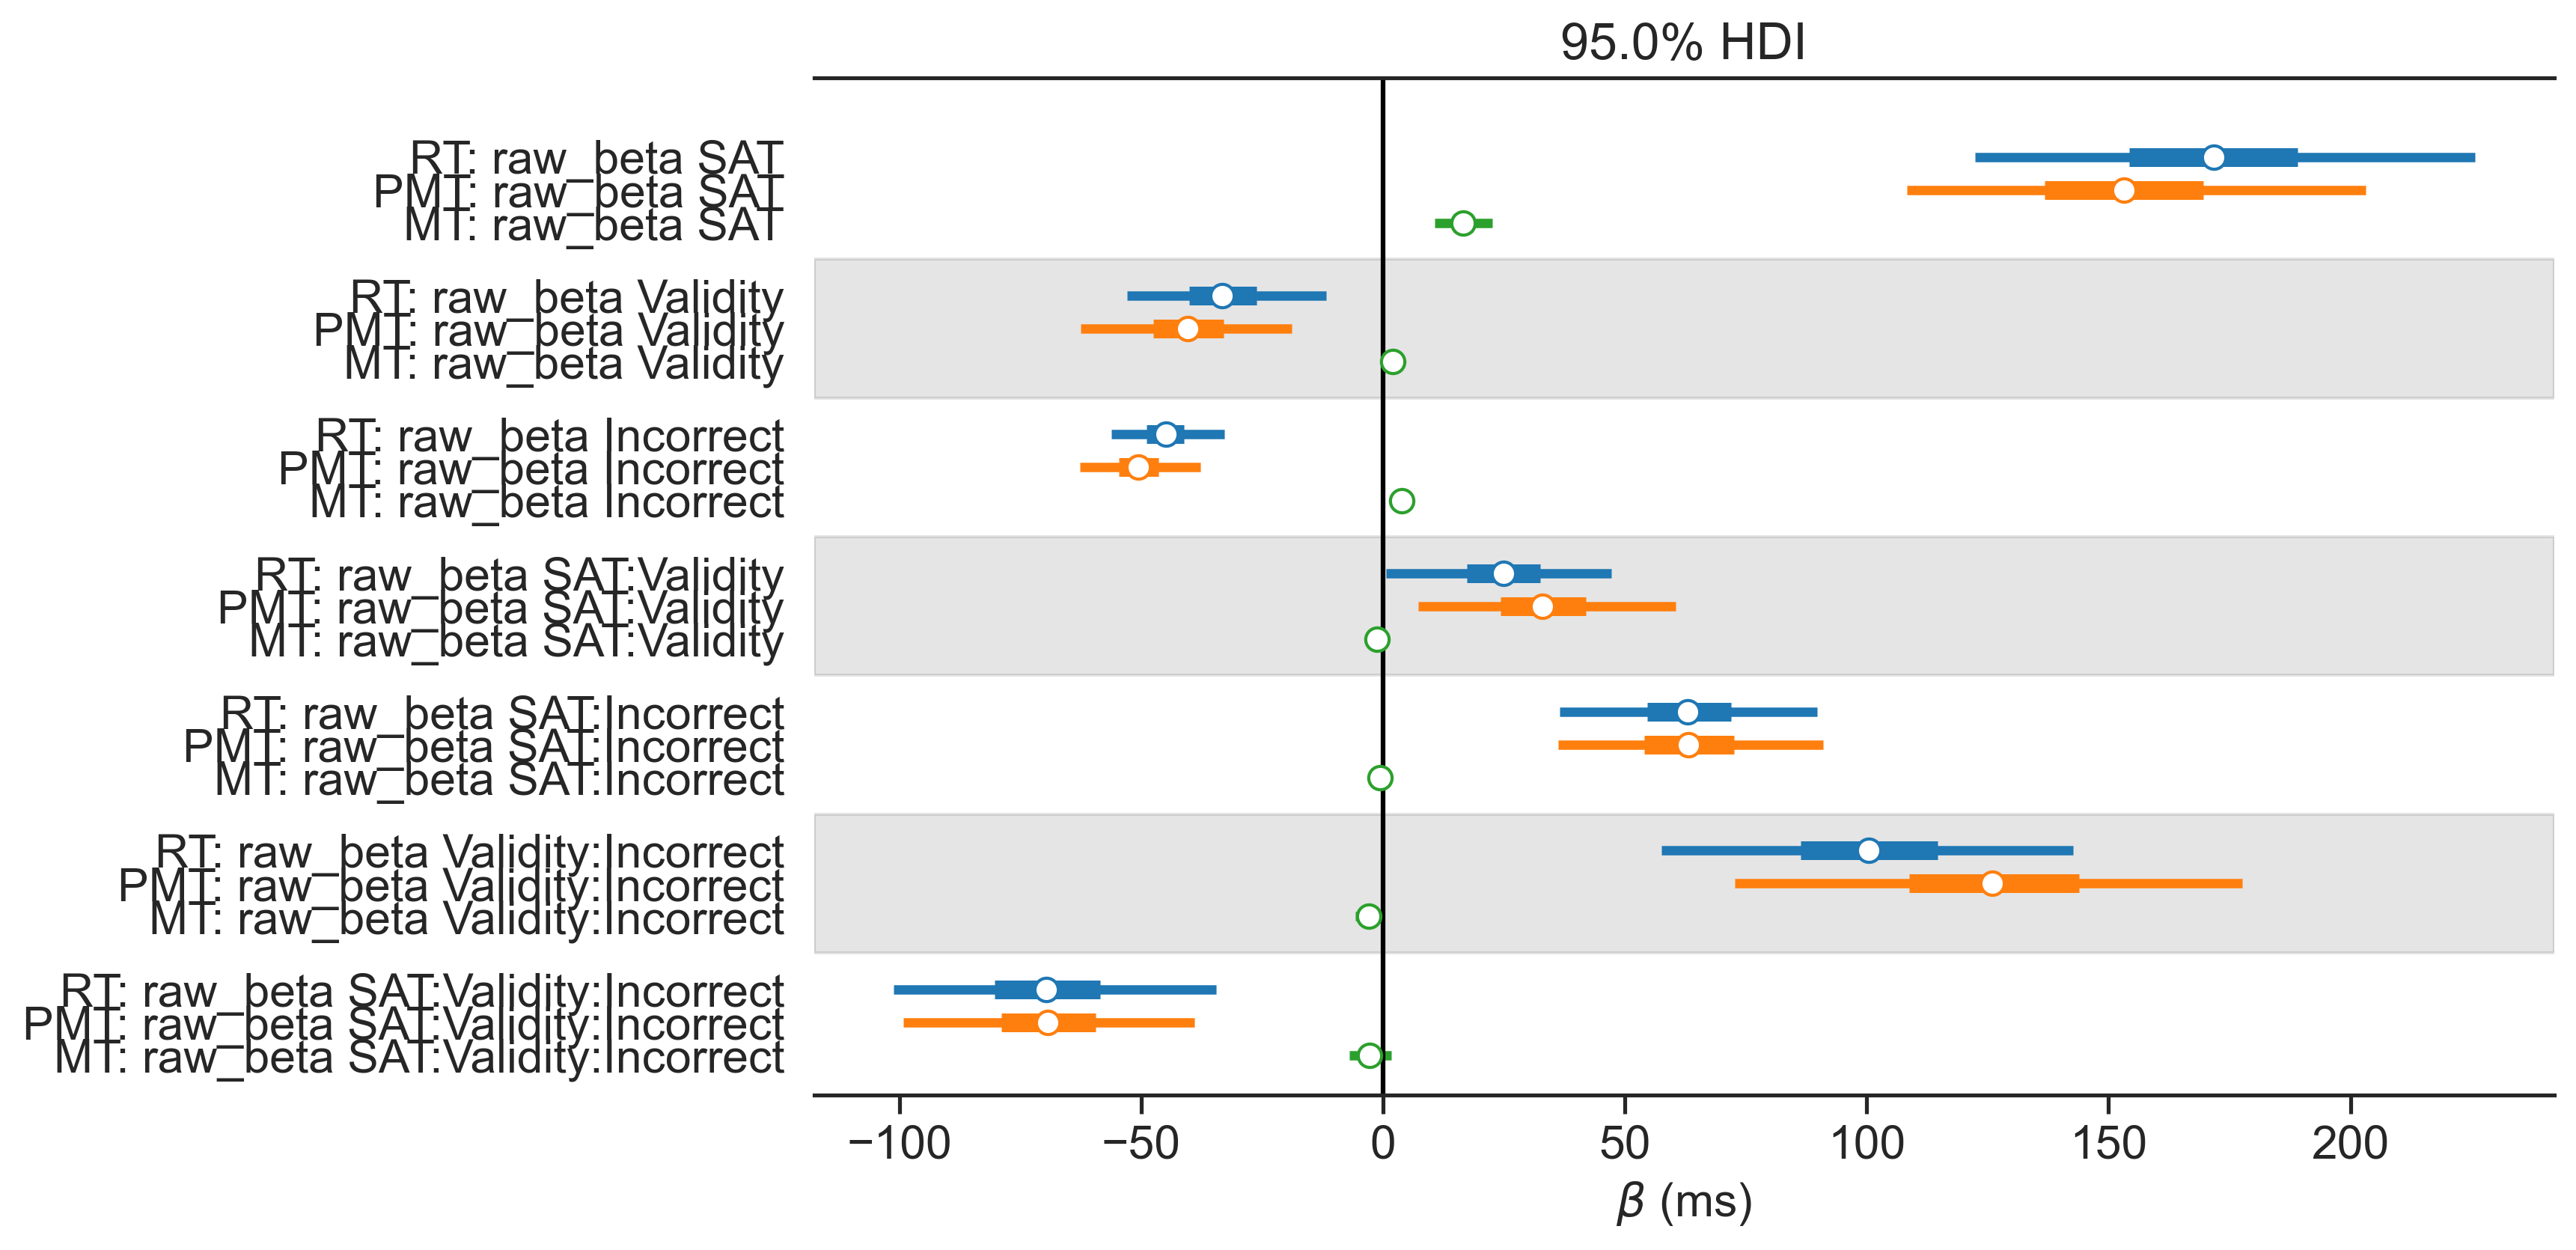

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=300)
_ = az.plot_forest(
    data=[RT_fit, PMT_fit, MT_fit], model_names=['RT','PMT', 'MT'], r_hat=False, ess=False,
    var_names=['raw_beta'], combined=True, rope=None, ax=ax, credible_interval=0.95,linewidth=3,
    markersize=10,textsize=15)
plt.vlines(0, -1, 20, 'k')
plt.xlabel(r'$\beta$ (ms)',fontsize=15)

## Joint plot

In [10]:
GLMEdata = pd.read_csv('MixedModels/GLMEdata.csv')

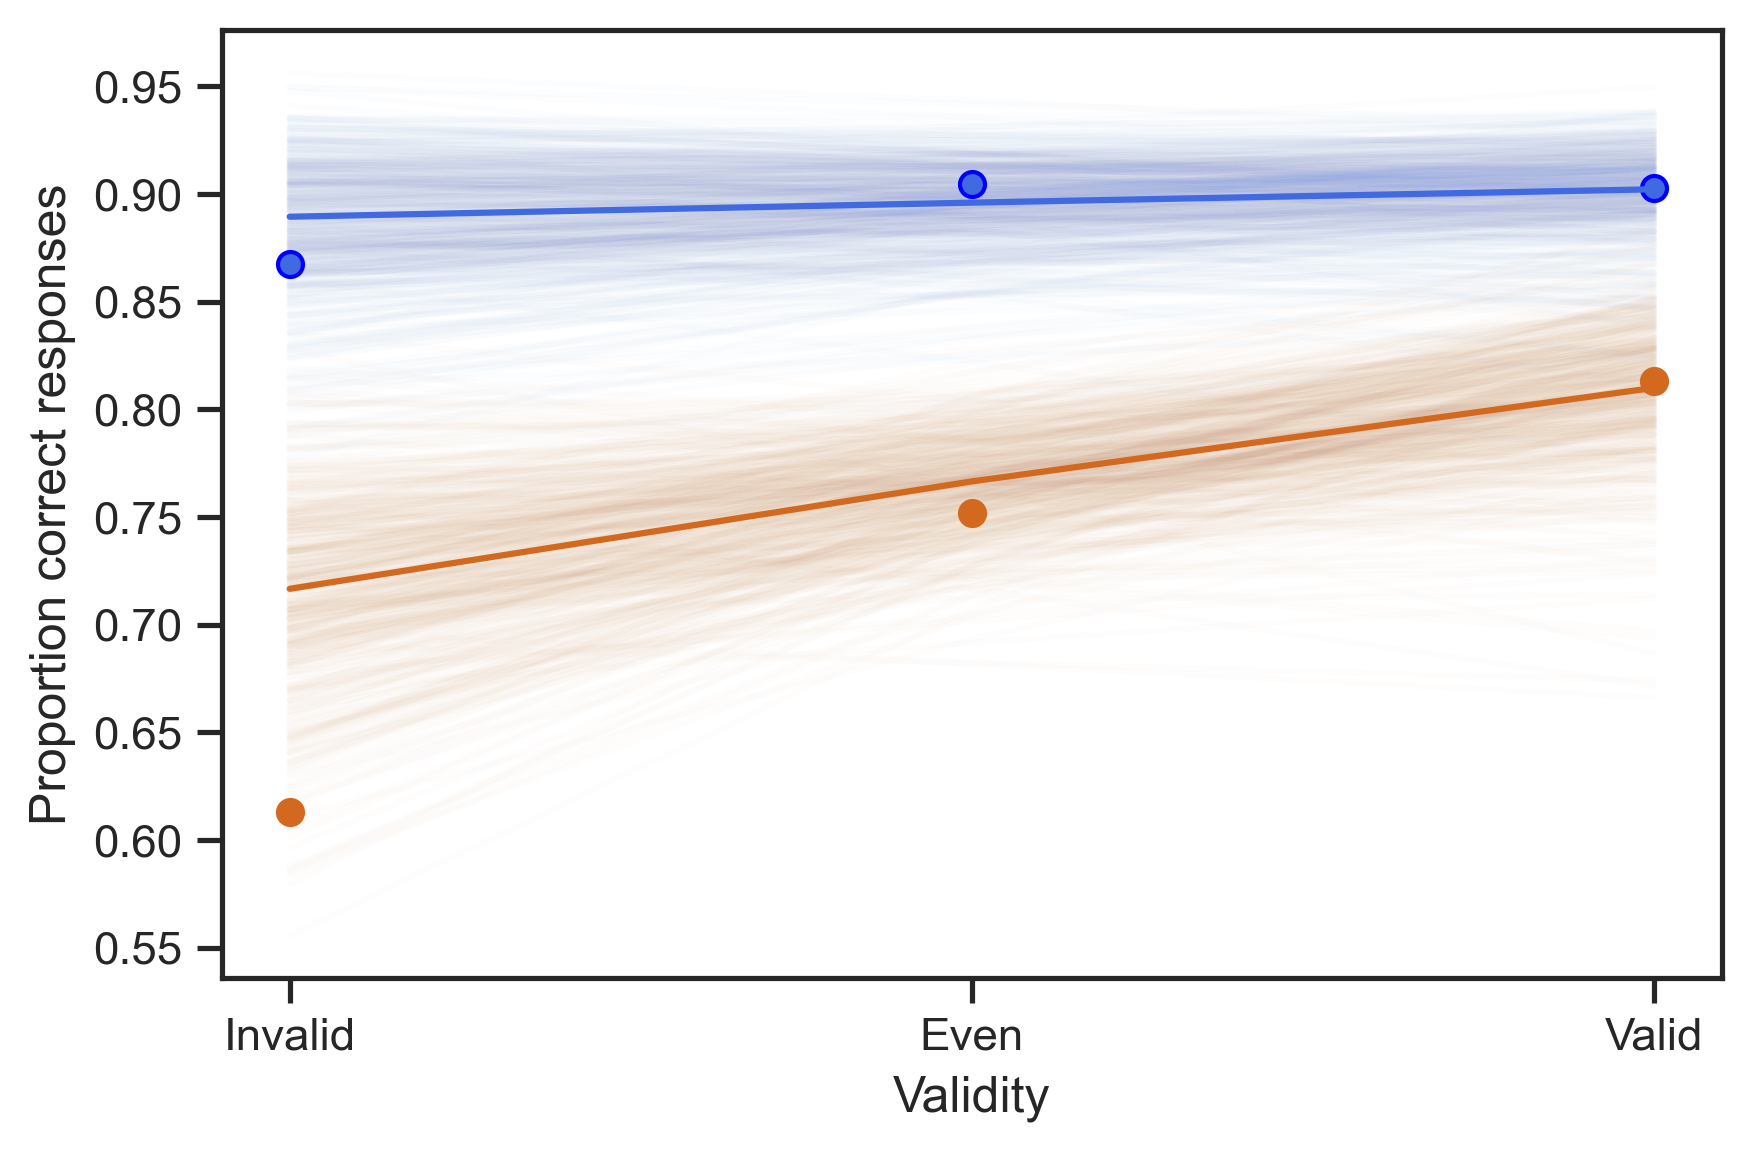

In [24]:
from scipy.special import expit
from random import sample

plt.figure(dpi=300)

fixeff_form = "1+SAT+Validity+SAT:Validity"#Fixed effects formula
fit = Precision_fit
param_dict = {val : idx for idx, val in enumerate(fixeff_form.split('+')[1:])} 
#fit.posterior.beta.coords['beta_dim_0'].values = fixeff_form.split('+')[1:]
alpha, beta = fit.posterior.alpha, fit.posterior.beta
samples,chains = fit.posterior.draw.values,fit.posterior.chain.values
display_range = validity = np.asarray([-0.5, .5])
validity = np.asarray([-0.5,0, .5])

for d in sample(list(samples),500):
    c = np.random.choice(chains)
    intercept, bSAT, bValidity, bSATValidity =  \
        alpha.sel(draw=d, chain=c).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT"]).values,\
        beta.sel(draw=d, chain=c, beta_dim_0=param_dict["Validity"]).values, \
        beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:Validity"]).values
    plt.plot(validity, expit(intercept+bSAT+validity*(bValidity+bSATValidity)), color="royalblue", alpha=.01)
    plt.plot(validity, expit(intercept+validity*(bValidity)), color="chocolate", alpha=.01)
intercept, bSAT, bValidity, bSATValidity  = \
    alpha.mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT"]).mean(axis=(0,1)).values,\
    beta.sel(beta_dim_0=param_dict["Validity"]).mean(axis=(0,1)).values, \
    beta.sel(beta_dim_0=param_dict["SAT:Validity"]).mean(axis=(0,1)).values
plt.ylabel('Proportion correct responses')
data = GLMEdata
dy = y = 'response'
F1 = data[(data.SAT==1)].groupby(['participant','Validity']).mean().groupby('Validity')
plt.plot(validity, F1[dy].mean().values,'o',color="royalblue", markeredgecolor ="b", label="accuracy")

F1 = data[(data.SAT==0)].groupby(['participant','Validity']).mean().groupby('Validity')
plt.plot(validity, F1[dy].mean().values,'o',color="chocolate", markeredgecolor ="chocolate", label="Speed")

plt.plot(validity, expit(intercept+bSAT+validity*(bValidity+bSATValidity)), color="royalblue")
plt.plot(validity, expit(intercept+validity*(bValidity)), color="chocolate")

plt.xticks([-0.5,0,0.5],['Invalid','Even','Valid'])
plt.xlabel('Validity')
plt.tight_layout()
plt.show()

In [16]:
LMEdata = pd.read_csv('MixedModels/LMEdata.csv')

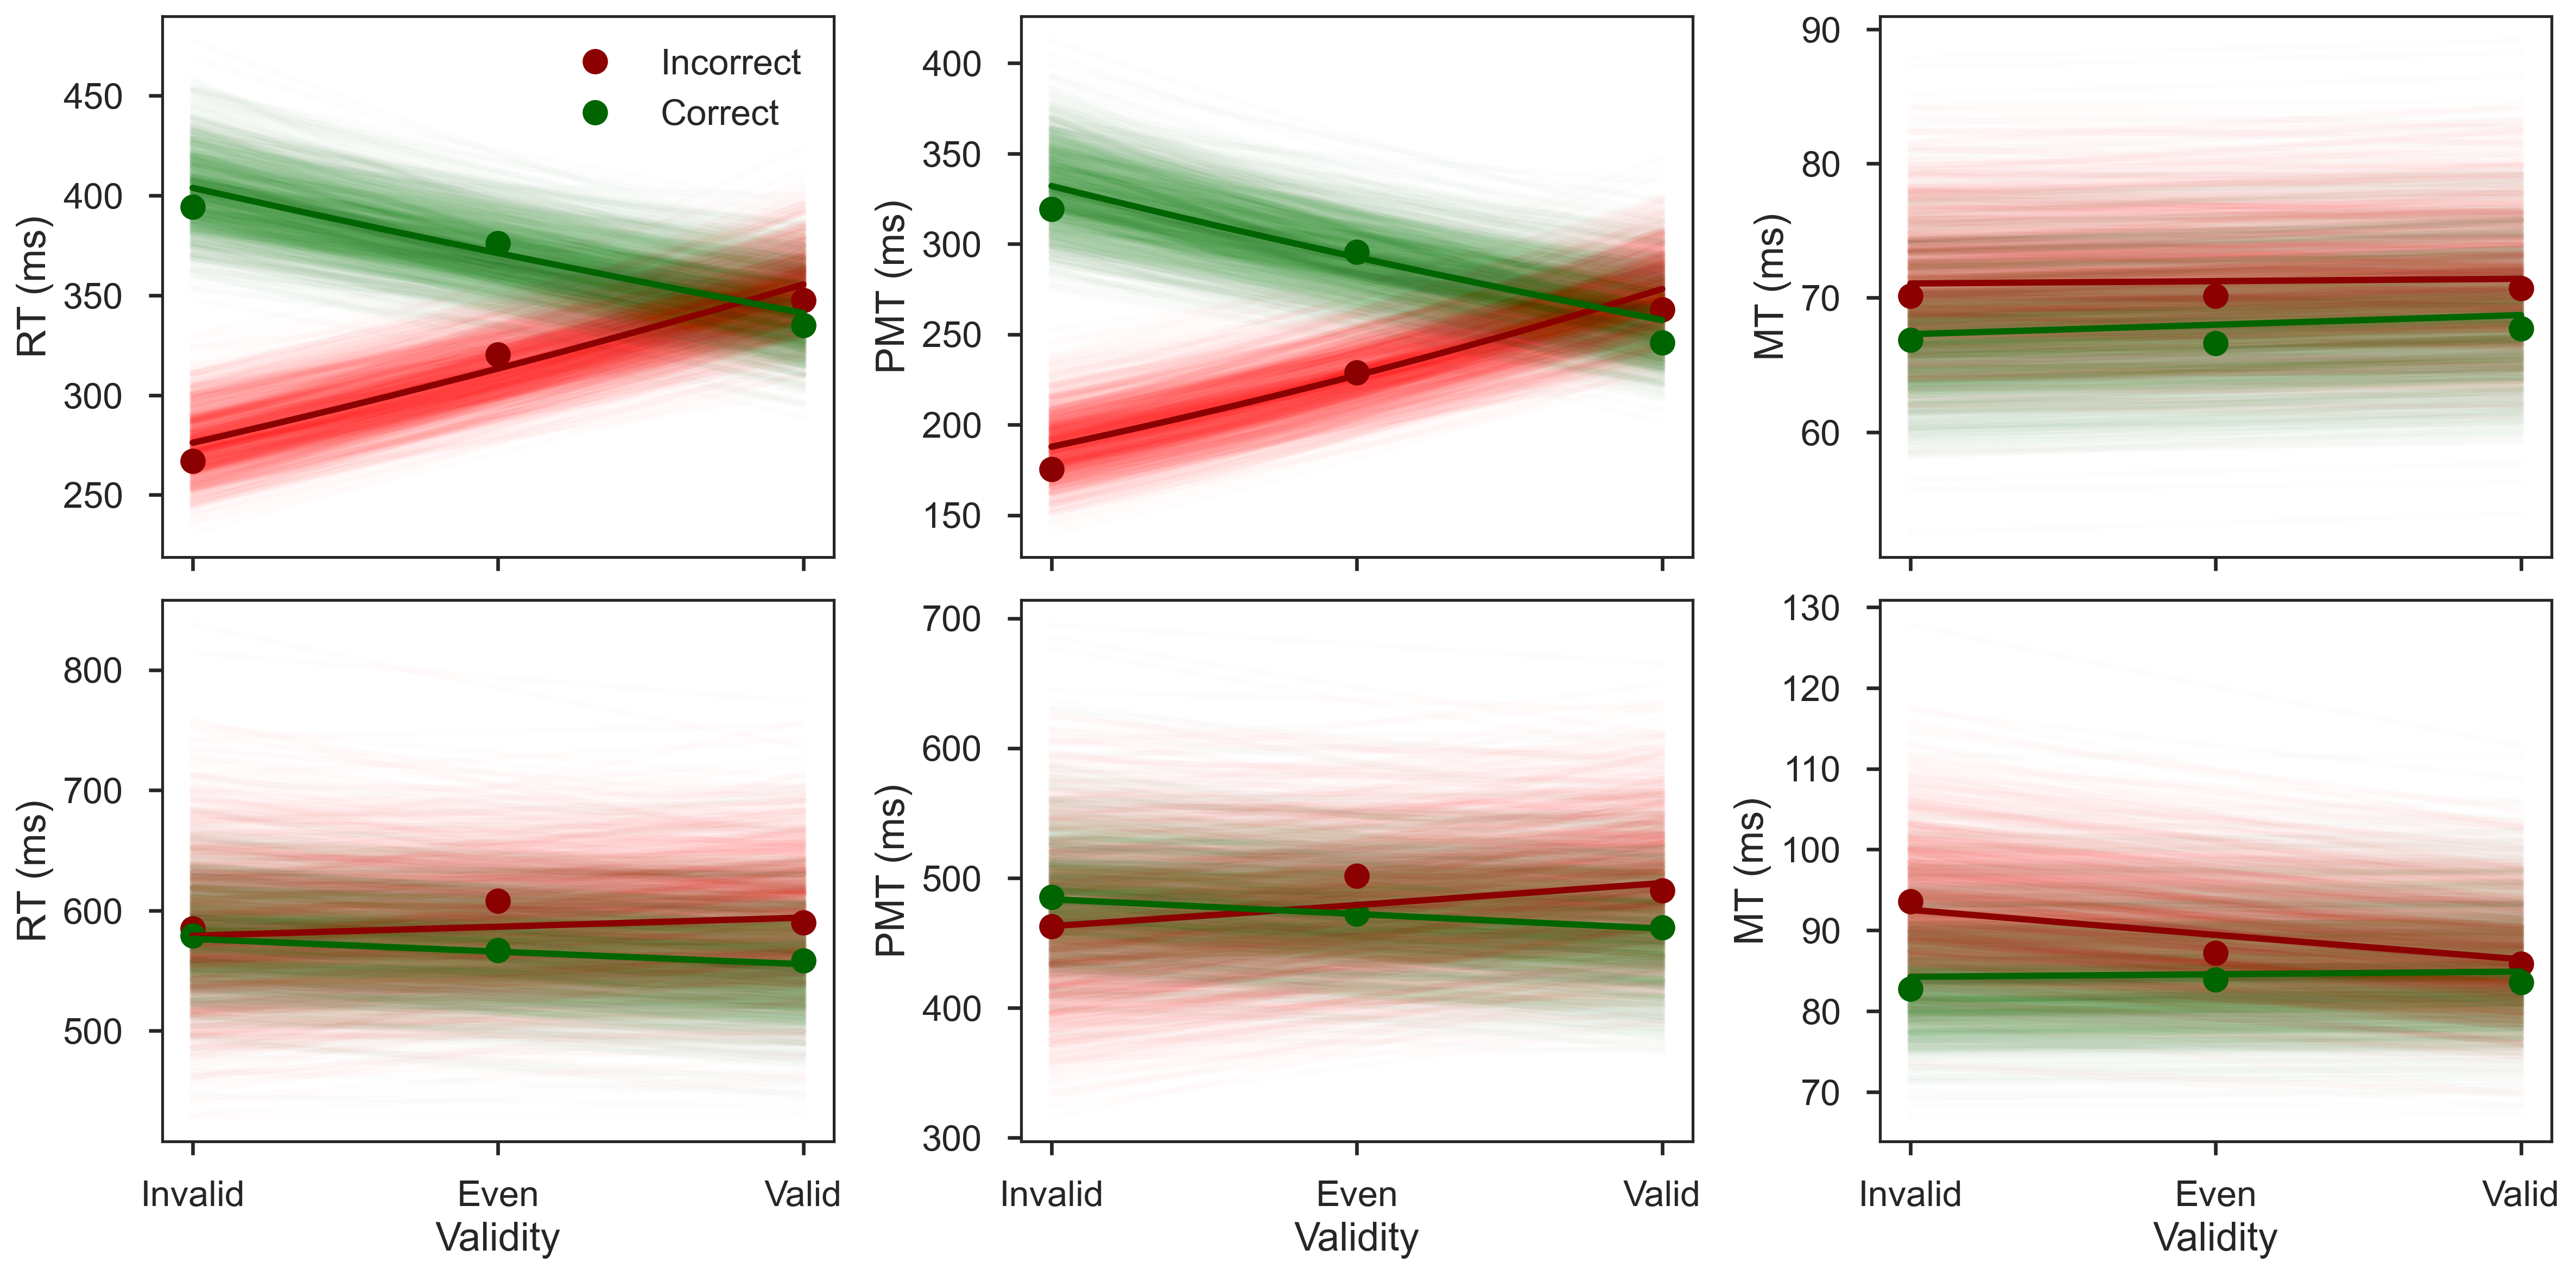

In [40]:
from scipy.special import expit
from random import sample

plt.style.use('seaborn-poster')


dv = {'rt':RT_fit,'prmt':PMT_fit,'mt':MT_fit}
order = {'rt':0,'prmt':1,'mt':2}
trans = {'rt':np.exp,'prmt':np.exp,'mt':np.exp }
upcase = {'rt':'RT','prmt':'PMT','mt':'MT'}
chron = ["rt","prmt","mt"]
fig, ax = plt.subplots(2,3, sharey=False, figsize=(16,8), sharex=True, dpi=300)

validity = np.linspace(-0.5,0.5,100)
display_range =  np.asarray([-0.5, 0, .5])

for y in dv.keys():
    fixeff_form = "1+SAT+Validity+Incorrect+SAT:Validity+SAT:Incorrect+Validity:Incorrect+SAT:Validity:Incorrect"#Fixed effects formula
    fit = dv[y]
    j = order[y]
    param_dict = {val : idx for idx, val in enumerate(fixeff_form.split('+')[1:])} 
    alpha, beta = fit.posterior.alpha, fit.posterior.beta
    samples,chains = fit.posterior.draw.values,fit.posterior.chain.values
    for z in np.arange(2):
        for d in sample(list(samples),1000):
            c = np.random.choice(chains)
            intercept, bSAT, bValidity, bIncorrect, bSATValidity, bSATIncorrect, bValidityIncorrect, bSATValidityIncorrect =  \
                alpha.sel(draw=d, chain=c).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["Validity"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["Incorrect"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:Validity"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:Incorrect"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["Validity:Incorrect"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:Validity:Incorrect"]).values
            ax[z, j].plot(validity, trans[y](intercept+bSAT*z+bValidity*validity+bIncorrect*1+bSATValidity*z*validity+bSATIncorrect*z*1+bValidityIncorrect*validity*1+bSATValidityIncorrect*z*validity*1), color="r", alpha=.01)
            ax[z, j].plot(validity, trans[y](intercept+bSAT*z+bValidity*validity+bIncorrect*0+bSATValidity*z*validity+bSATIncorrect*z*0+bValidityIncorrect*validity*0+bSATValidityIncorrect*z*validity*0), color="g", alpha=.01)
        intercept, bSAT, bValidity, bIncorrect, bSATValidity, bSATIncorrect, bValidityIncorrect, bSATValidityIncorrect =  \
            alpha.mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["Validity"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["Incorrect"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["SAT:Validity"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT:Incorrect"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["Validity:Incorrect"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT:Validity:Incorrect"]).mean(axis=(0,1)).values

        ax[z, j].set_ylabel('%s (ms)' %upcase[y])
        dy = 'log' + y
        data = LMEdata.copy()
        F1 = data[(data.SAT==z) & (data.Incorrect==1)].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
        F2 = data[(data.SAT==z) & (data.Incorrect==0)].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
        if 'log' in dy:
            ax[z, j].plot(display_range, trans[y](F1[dy].mean().values),'o',color="darkred", markeredgecolor ="k", label="Incorrect")
            ax[z, j].plot(display_range, trans[y](F2[dy].mean().values),'o',color="darkgreen", markeredgecolor ="k", label="Correct")
        else : 
            ax[z, j].plot(np.linspace(23,93,6), F1[dy].mean().values,'o',color="blue", markeredgecolor ="k", label="Weak")
            ax[z, j].plot(np.linspace(23,93,6), F2[dy].mean().values,'o',color="g", markeredgecolor ="k", label="Strong")
        ax[z, j].plot(validity, trans[y](intercept+bSAT*z+bValidity*validity+bIncorrect*1+bSATValidity*z*validity+bSATIncorrect*z*1+bValidityIncorrect*validity*1+bSATValidityIncorrect*z*validity*1), color="darkred")
        ax[z, j].plot(validity,trans[y](intercept+bSAT*z+bValidity*validity+bIncorrect*0+bSATValidity*z*validity+bSATIncorrect*z*0+bValidityIncorrect*validity*0+bSATValidityIncorrect*z*validity*0), color="darkgreen")
        ax[z, j].set_xticks([-0.5,0,0.5])
        if z == 1:
            ax[z, j].set_xticklabels(['Invalid','Even','Valid'])
            ax[z, j].set_xlabel('Validity')
        if j == 0 and z == 0:
            ax[z, j].legend(loc=1)
plt.tight_layout()
plt.show()

## Comparison of the random effect of the validity effect on the different variables

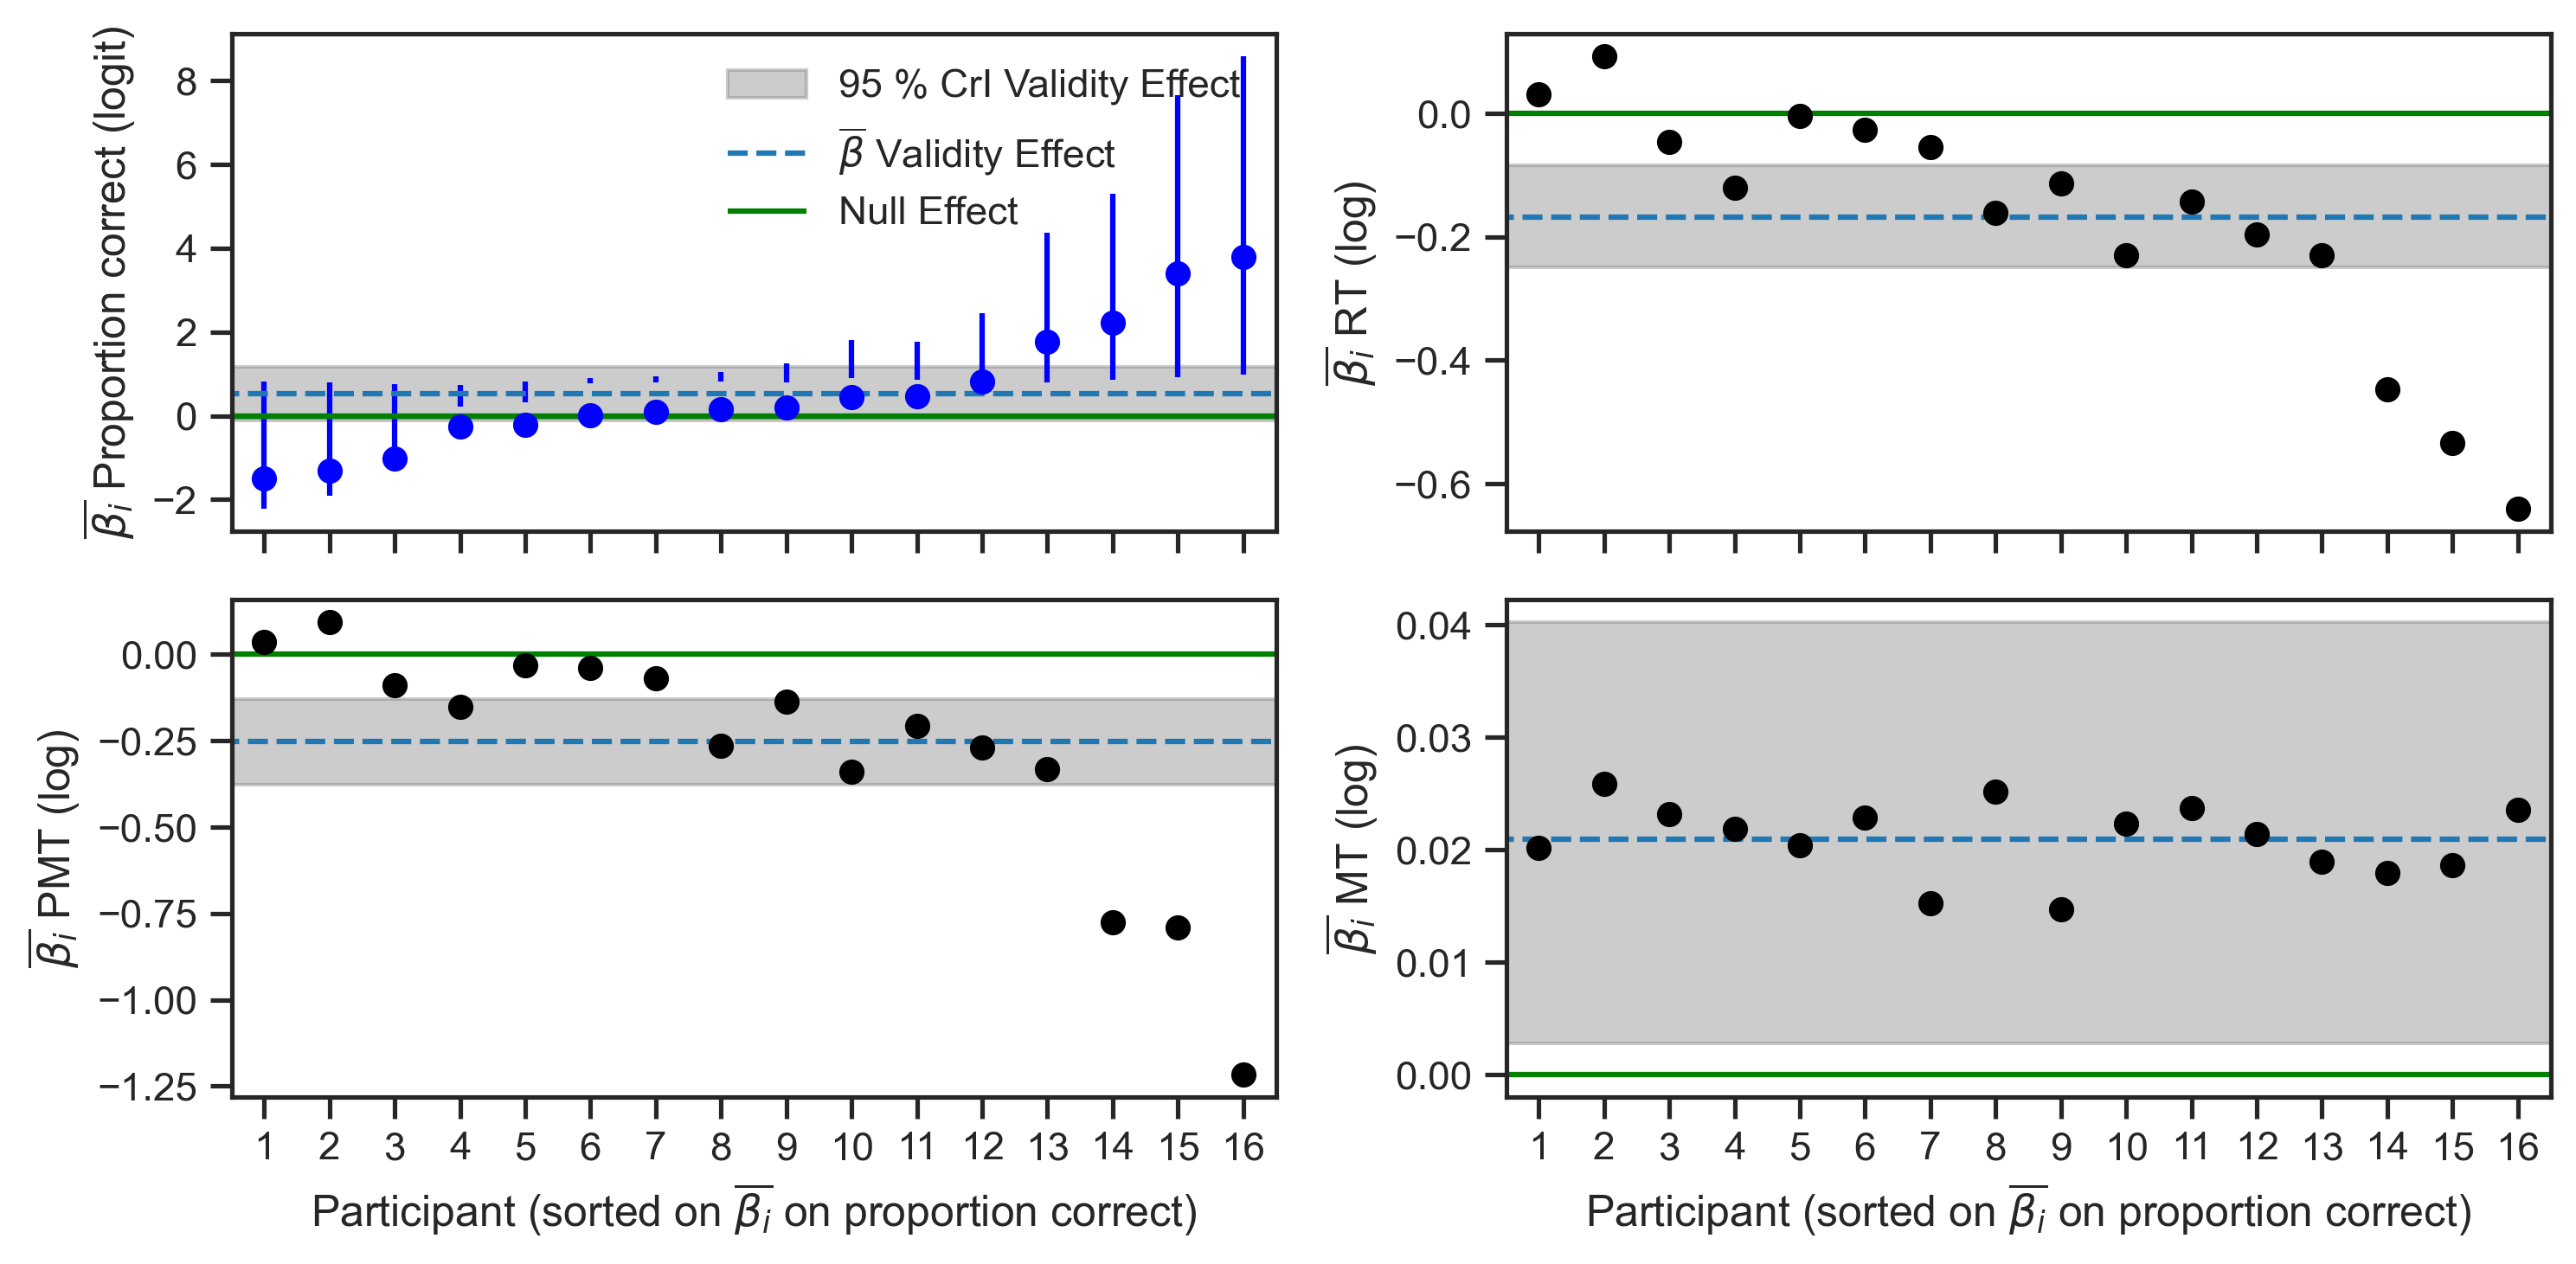

In [36]:
from scipy.special import expit

figr, ax = plt.subplots(2,2, figsize=(10,5), sharey=False,sharex=True,dpi=300)
mean_Validity_prec = Precision_fit.posterior.beta.sel(beta_dim_0=1).mean(axis=(0,1)).values 
indiv_Validity_prec = mean_Validity + Precision_fit.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values
CrI_i = az.hdi(Precision_fit.posterior.u.sel(u_dim_1=2),hdi_prob=.95)
upper =   CrI_i.sel(hdi='lower').u
lower =   CrI_i.sel(hdi='higher').u
df_var_prec = pd.DataFrame(indiv_Validity_prec)
index_to_sort = df_var_prec.sort_values(0).index

#ax[0,0].plot(np.arange(16)+1, indiv_Validity_prec[index_to_sort],'o',label='Individual estimated Validity effect',color='k')
ax[0,0].errorbar(np.arange(16)+1, indiv_Validity_prec[index_to_sort], yerr=[upper[index_to_sort],lower[index_to_sort]],fmt='o', color='blue')
ax[0,0].hlines(0, -1, 17)

ax[0,0].hlines(mean_Validity_prec, -1,17, linestyle='--', label=r"$\overline{\beta}$ Validity Effect")
lower, upper = az.hdi(Precision_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[0], az.hdi(Precision_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
ax[0,0].fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4, label="95 % CrI Validity Effect")

ax[0,0].hlines(0, -1, 17,label="Null Effect", color="g")
ax[0,0].set_xlim(0.5,16.5)
ax[0,0].set_xticks(np.arange(16)+1)
#plt.title('Individual Effects of Validity on precision  \n\n', fontsize=15)
ax[0,0].set_ylabel(r'$\overline{\beta_i}$ Proportion correct (logit)')
ax[0,0].legend(loc=0)

mean_Validity_RT = RT_fit.posterior.beta.sel(beta_dim_0=1).mean(axis=(0,1)).values 
indiv_Validity_RT = mean_Validity_RT + RT_fit.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values

ax[0,1].plot(np.arange(16)+1, indiv_Validity_RT[index_to_sort],'o',color='k')
ax[0,1].hlines(0, -1, 17,color='g')

ax[0,1].hlines(mean_Validity_RT, -1,17, linestyle='--', label="Estimated Validity Effect")
lower, upper = az.hdi(RT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[0], az.hdi(RT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
ax[0,1].fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)
ax[0,1].set_ylabel(r'$\overline{\beta_i}$ RT (log)')

mean_Validity_PMT = PMT_fit.posterior.beta.sel(beta_dim_0=1).mean(axis=(0,1)).values 
indiv_Validity_PMT = mean_Validity_PMT + PMT_fit.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values

ax[1,0].plot(np.arange(16)+1, indiv_Validity_PMT[index_to_sort],'o',color='k')
ax[1,0].hlines(0, -1, 17,color='g')

ax[1,0].hlines(mean_Validity_PMT, -1,17, linestyle='--', label="Estimated Validity Effect")
lower, upper = az.hdi(PMT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[0], az.hdi(PMT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
ax[1,0].fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)
ax[1,0].set_ylabel(r'$\overline{\beta_i}$ PMT (log)')
ax[1,0].set_xlabel(r'Participant (sorted on $\overline{\beta_i}$ on proportion correct)')
mean_Validity_MT = MT_fit.posterior.beta.sel(beta_dim_0=1).mean(axis=(0,1)).values 
indiv_Validity_MT = mean_Validity_MT + MT_fit.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values

ax[1,1].plot(np.arange(16)+1, indiv_Validity_MT[index_to_sort],'o',color='k')
ax[1,1].hlines(0, -1, 17,color='g')

ax[1,1].hlines(mean_Validity_MT, -1,17, linestyle='--', label="Estimated Validity Effect")
lower, upper = az.hdi(MT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[0], az.hdi(MT_fit.posterior.beta.sel(beta_dim_0=1), hdi_prob=.95).beta.values[1]
ci95pos,ci95neg = upper, lower
ax[1,1].fill([-1, 17, 17, -1], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)
ax[1,1].set_ylabel(r'$\overline{\beta_i}$ MT (log)')
ax[1,1].set_xlabel(r'Participant (sorted on $\overline{\beta_i}$ on proportion correct)')

plt.tight_layout()
plt.savefig('RandomEffects.png', bbox_inches='tight',dpi=300)